In [1]:
#Import the libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline

In [2]:
def load_data(prob_path,stock_path):
    prob=pd.read_csv(prob_path,encoding='utf-8')
    #取得文章時間
    stock=pd.read_csv(stock_path,encoding="utf-8")
    prob.預計影響日期 = prob.預計影響日期.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    stock.time = stock.time.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    merge = stock.merge(prob,left_on='time', right_on='預計影響日期',how='outer')
    merge = merge.rename(columns={"預計影響日期": "effect_time", "觀光類指數": "tourism","生技醫療類指數": "medical"})
    return merge
df = load_data(prob_path,stock_path)

In [3]:
df[df["effect_time"].isnull()].head()  #最晚一天的null是0117

,medical,tourism,time,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,effect_time,預計影響日期.1
232246,64.72,98.46,2020-01-17 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
232247,64.68,98.52,2020-01-17 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
232249,64.71,98.46,2020-01-17 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
232250,64.62,98.50,2020-01-17 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
232269,64.59,98.30,2020-01-16 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [4]:
#column = 想測試的類股
def prepare_training_testing_data(data,column,after,before):
    
    #準備x值
    df_sum = data.groupby('time').sum()
    
    #準備y值
    df_mean = data.groupby('time').mean()
    
    #將index轉回數字
    df_mean["number"] = range(len(df_mean))
    df_mean["time1"] = df_mean.index
    df_mean = df_mean.set_index(["number"])
    
    #將y值轉為label encoding
    for n in range(len(df_mean)):
        if n < len(df_mean)-1:
            if df_mean.loc[n,column] > df_mean.loc[n+1,column]:
                df_mean.loc[n+1,"label"] = 0
            elif df_mean.loc[n,column] < df_mean.loc[n+1,column]:
                df_mean.loc[n+1,"label"] = 1
            elif df_mean.loc[n,column] == df_mean.loc[n+1,column]:
                df_mean.loc[n+1,"label"] = 2
    
    #篩選日期
    date = pd.to_datetime(after, format='%Y%m%d')
    date2 = pd.to_datetime(before, format='%Y%m%d')
    df_mean = df_mean[df_mean['time1'].dt.date > date]
    df_mean = df_mean[df_mean['time1'].dt.date < date2]
    df_sum = df_sum[df_sum.index.date > date]
    df_sum = df_sum[df_sum.index.date < date2]
    
    dataset = df_sum.drop(['tourism','medical'],axis=1)
    
    #one_hot
    values = np.asarray(df_mean["label"])
    values = values.astype(int)
    n_class = np.max(values) + 1
    encoding_result = np.eye(n_class)[values]
    
    return dataset, encoding_result
features, label = prepare_training_testing_data(df,'tourism','20200117','20201231')

In [5]:
def split_training_testing_data(dataset,label,n_features,training_partition,time_step):
    
    training_data_len = math.ceil( len(dataset) *training_partition) #計算training和testing data區分處
    
    # 將pd.DataFrame 轉成 numpy array
    dataset = dataset.values
    
    # 將資料標準化，先轉為(n,1)形狀
    dataset = dataset.reshape(-1,1)
    
    # 將資料標準化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    #將資料調回原本的形狀
    scaled_data = scaled_data.reshape(-1,n_features)
    
    # 將資料切分為training & testing data 
    
    x_train,y_train,x_test,y_test = [],[],[],label[training_data_len : , : ] 
    
    train_data = scaled_data[0:training_data_len, : ]
    train_label = label[0:training_data_len, : ]

    test_data = scaled_data[training_data_len - time_step: , : ]
    test_label = label[0:training_data_len, : ]
      

    # 準備training data 
    for i in range(time_step,len(train_data)):
        x_train.append(train_data[i-time_step:i,:])
        y_train.append(train_label[i,:])
        
    # 準備testing data
    for i in range(time_step,len(test_data)):
        x_test.append(test_data[i-time_step:i,:])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    
    return x_train, y_train, x_test, y_test,scaler,training_data_len
   
x_train, y_train, x_test, y_test,scaler,training_data_len = split_training_testing_data(features,label,18,0.8,30)    

In [6]:
def train_LSTM(x_train,y_train):
    
    #Build the LSTM network model
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64, return_sequences=True,input_shape= x_train.shape[1:]))
    model.add(keras.layers.LSTM(units=64, return_sequences=False))
    model.add(keras.layers.Dense(units=32))
    model.add(keras.layers.Dense(3,activation="softmax"))

    #Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])
    
    print(model.summary())

    #Train the model
    print('Start training model...')
    history = model.fit(x_train, y_train, batch_size=128, epochs=20)
    
    return model,history

model,history = train_LSTM(x_train,y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            21248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 56,451
Trainable params: 56,451
Non-trainable params: 0
_________________________________________________________________
None
Start training model...
Epoch 1/20
15/15 [==============================] - 4s 46ms/step - loss: 1.0328 - acc: 0.5074
Epoch 2/20
15/15 [==============================] - 1s 48ms/step - loss: 0.8116 - acc: 0.4598
Epoch 3/20
15/15 [===============

In [7]:
def test_LSTM(x_test,y_test):
    predictions = model.predict(x_test)
    y_predicted = pd.DataFrame(predictions)
    y_predicted = y_predicted.idxmax(axis = 1)
    
    y_val = pd.DataFrame(y_test)
    y_val = y_val.idxmax(axis=1)
    
    return y_predicted,y_val

predictions, y_val = test_LSTM(x_test,y_test)

In [8]:
cm = confusion_matrix(y_val, predictions)

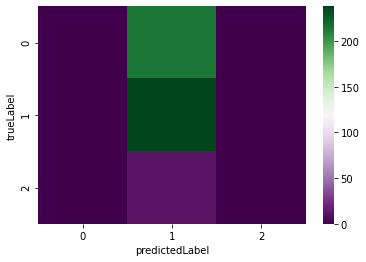

In [9]:
sns.heatmap(cm, cbar = True, cmap = 'PRGn')
plt.xlabel('predictedLabel')
plt.ylabel('trueLabel');

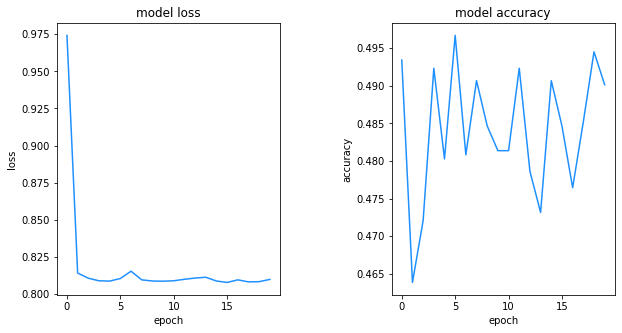

In [10]:
def plot_history_loss(fit):
    axL.plot(fit.history['loss'], label = "for training", color = 'dodgerblue')
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
def plot_history_accuracy(fit):
    axR.plot(fit.history['acc'], label = "for training", color = 'dodgerblue')
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')

fig, (axL, axR) = plt.subplots(ncols = 2, figsize = (10,5))
plt.subplots_adjust(wspace = 0.5)
plot_history_loss(history)
plot_history_accuracy(history)
fig.savefig("loss_and_accuracy_LSTM.png", format = 'png', dpi = 300)
